In [1]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
pd.options.display.max_columns = None
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot


In [2]:
libs = {}
libs['SRR1197125'] = 'SRR1197125_germinating_seed_embryo'
libs['SRR1197126'] = 'SRR1197126_seedling_leaf'
libs['SRR1197127'] = 'SRR1197127_seedling_root'
libs['SRR1197128'] = 'SRR1197128_grain_8_days_after_pollination'

path_base = '/home/juan/Documents/dev/mirna_mite/'
path_annotation = '../data/Triticum_aestivum.IWGSC.47.gff3'
path_libs = '../data/res/sun_deg/%s'
path_transcripts = '../data/fixed.cdna.all.fa'
path_transcripts_res = '../data/res/targets.fa'
path_blast_res = '../data/res/transcripts_mites.csv'
path_blast_res_filtered = '../data/res/transcripts_mites.filtered.csv'
path_mirna_res = '../data/res/all_results.csv'
path_res_target = '../data/res/res_target.csv'
path_res_prod_mite_target_all = '../data/res/res_prod_mites_target_all.csv'
path_res_final = '../data/res/res_prod_target.csv'
path_psrna = '../data/res/psRNATargetJob-1592088226490786.txt'


In [3]:
dfs = []
for lib,description in libs.items():
    path_lib = path_libs % lib
    df = pd.read_csv(path_lib, sep='\t',comment='#')
    print(lib, len(df.index))
    df['lib'] = description
    dfs.append(df)


SRR1197125 3347
SRR1197126 4916
SRR1197127 6193
SRR1197128 2110


In [4]:
df = pd.concat(dfs)
print(len(df.index))

16566


In [5]:
df.drop_duplicates(['SiteID','Query','lib'], inplace=True)
print(len(df.index))

16566


In [6]:
df = df.reset_index(drop=True)


In [7]:
df = df[df.DegradomeCategory <= 3]
print(len(df.index))

7002


In [8]:
df = df[df.DegradomePval < 0.05]
print(len(df.index))

455


In [9]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
15,TraesCS1A02G058400.2:1721,sun_all_Cluster_115609_6A_607452425_607452573,TraesCS1A02G058400.2,1710,1730,1721,-34.3,-34.2,0.997085,2.0,"1-20,1730-1711","21-21,1710-1710[UP3]",.((((((((((((((((((((&)))))))))))))))))))).,CUGCAGCAUCAUCAGGAUUCU&AGAAUCUUGAUGAUGCUGCAU,2,0.005693,../data/res/sun_plots/SRR1197125/sun_all_Clust...,SRR1197125_germinating_seed_embryo
163,TraesCS1B02G076300.1:1739,sun_all_Cluster_129257_7A_8252397_8252530,TraesCS1B02G076300.1,1728,1748,1739,-34.3,-34.2,0.997085,2.0,"1-20,1748-1729","21-21,1728-1728[UP3]",.((((((((((((((((((((&)))))))))))))))))))).,CUGCAGCAUCAUCAGGAUUCU&AGAAUCUUGAUGAUGCUGCAU,3,0.004176,../data/res/sun_plots/SRR1197125/sun_all_Clust...,SRR1197125_germinating_seed_embryo


In [10]:
df_psrna = pd.read_csv(path_psrna, sep='\t', comment='#')
print(len(df_psrna.index))
df_psrna = df_psrna[df_psrna['Inhibition'] == 'Cleavage']
print(len(df_psrna.index))
df_psrna.head(2)

44296
37687


,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6D02G238900.1,0.0,-1.0,1,21,577,597,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6D:339389350:339390413:1...,1
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6A02G257600.1,0.0,-1.0,1,21,559,579,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6A:479833651:479834702:1...,1


In [11]:
df_psrna.columns

Index(['miRNA_Acc.', 'Target_Acc.', 'Expectation', 'UPE$', 'miRNA_start',
       'miRNA_end', 'Target_start', 'Target_end', 'miRNA_aligned_fragment',
       'alignment', 'Target_aligned_fragment', 'Inhibition', 'Target_Desc.',
       'Multiplicity'],
      dtype='object')

In [12]:
df_res_1 = pd.merge(df_psrna, df,  left_on=['miRNA_Acc.','Target_Acc.','Target_start'], right_on=['Query','Transcript','TStart'])
print(len(df_res_1.index))
df_res_1.head(2)

326


,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000393,../data/res/sun_plots/SRR1197126/mrcv_all_Clus...,SRR1197126_seedling_leaf
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,3,0.004493,../data/res/sun_plots/SRR1197127/mrcv_all_Clus...,SRR1197127_seedling_root


In [13]:
df_res_2 = pd.merge(df_psrna, df, left_on=['miRNA_Acc.','Target_Acc.','Target_end'], right_on=['Query','Transcript','TStop'])
print(len(df_res_2.index))
df_res_2.head(2)

350


,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000393,../data/res/sun_plots/SRR1197126/mrcv_all_Clus...,SRR1197126_seedling_leaf
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,3,0.004493,../data/res/sun_plots/SRR1197127/mrcv_all_Clus...,SRR1197127_seedling_root


In [14]:
df_res = pd.concat([df_res_1, df_res_2])
print(len(df_res.index))
df_res = df_res.drop_duplicates()
print(len(df_res.index))

676
352


In [15]:
df_res['new_start'] = df_res[['Target_start','Target_end']].min(axis=1)
df_res['new_end'] = df_res[['Target_start','Target_end']].max(axis=1)
df_res['Target_start'] = df_res['new_start']
df_res['Target_end'] = df_res['new_end']
df_res = df_res.drop('new_start',axis=1).drop('new_end',axis=1)
df_res = df_res.drop_duplicates()
print(len(df_res.index))

352


In [16]:
df = df_res

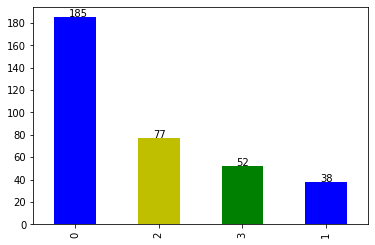

In [17]:
ax = df.DegradomeCategory.value_counts().plot(kind='bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


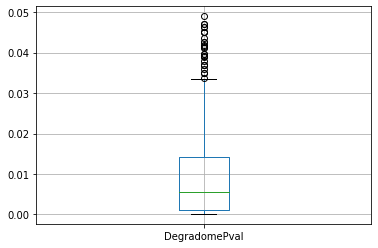

In [18]:
df.boxplot(column=['DegradomePval'])


In [19]:
print(len(df[df.DegradomePval < 0.05].index))

352


In [20]:
df.Transcript.nunique()

227

In [21]:
df['gene'] =  df.Transcript.str.split('.').str[0]

In [22]:
df.head(2)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000393,../data/res/sun_plots/SRR1197126/mrcv_all_Clus...,SRR1197126_seedling_leaf,TraesCS6B02G267500
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,3,0.004493,../data/res/sun_plots/SRR1197127/mrcv_all_Clus...,SRR1197127_seedling_root,TraesCS6B02G267500


In [23]:
df.gene.nunique()

198

In [24]:
df.Query.nunique()

93

In [25]:
transcripts = set()
for k,v in df.iterrows():
    transcript = v.Transcript
    transcripts.add(transcript)

In [26]:
fasta_seq = SeqIO.parse(path_transcripts, 'fasta')


In [27]:
lens = {}
buffer_seqs = []
for record in fasta_seq:
    if record.id in transcripts:
        buffer_seqs.append(record)
        clean_seq = ''.join(str(record.seq).splitlines())
        lens[record.id] = len(clean_seq)
SeqIO.write(buffer_seqs, path_transcripts_res, "fasta")
print(len(buffer_seqs))
print(path_transcripts_res)

227
../data/res/targets.fa


In [28]:
path_blast_res

'../data/res/transcripts_mites.csv'

In [29]:
df_mites = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mites.columns = cols

df_mites = df_mites[df_mites.pident >= 80]
df_mites = df_mites[(df_mites.length / df_mites.qlen) >= 0.8]

print(len(df_mites.index))
df_mites.head(2)

635


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3474,3394,7,1,90.123,1.190000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,1.190000e-25,81,80,3296,100,118


In [30]:
df['new_start'] = df[['TStart','TStop']].min(axis=1)
df['new_end'] = df[['TStart','TStop']].max(axis=1)
df['TStart'] = df['new_start']
df['TStop'] = df['new_end']
df = df.drop('new_start',axis=1).drop('new_end',axis=1)


In [31]:
df_mites['new_start'] = df_mites[['sstart','send']].min(axis=1)
df_mites['new_end'] = df_mites[['sstart','send']].max(axis=1)
df_mites['sstart'] = df_mites['new_start']
df_mites['send'] = df_mites['new_end']
df_mites = df_mites.drop('new_start',axis=1).drop('new_end',axis=1)


In [32]:
df_mites.head(4)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,1.190000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,1.190000e-25,81,80,3296,100,118
2,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,1.190000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,6.190000e-23,81,80,1296,100,108


In [33]:
df_mites = df_mites.drop_duplicates()


In [34]:
print(len(df_mites.index))
df_mites.head(8)

612


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,1.190000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,1.190000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,6.190000e-23,81,80,1296,100,108
5,MITE_0,TraesCS1D02G273500.1,1,80,916,996,9,1,87.654,6.190000e-23,81,80,1243,100,108
7,MITE_0,TraesCSU02G068000.1,3,80,2383,2461,9,1,87.342,7.540000e-22,79,80,3325,100,104
8,MITE_0,TraesCSU02G068000.1,1,78,2383,2461,9,1,87.342,7.540000e-22,79,80,3325,100,104
9,MITE_0,TraesCS6B02G168300.1,1,80,1142,1222,11,1,85.185,3.200000e-20,81,80,1610,100,98
11,DTT_Taes_Icarus_BJ272697-1,TraesCS2B02G228200.1,1,111,1104,1214,8,0,92.793,7.520000e-43,111,111,2186,100,182


In [35]:
#c_maxes = df_mites.groupby(['qseqid', 'sseqid']).score.transform(max)
#df_mites = df_mites.loc[df_mites.score == c_maxes]


In [36]:
df_mites.head(4)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,1.190000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,1.190000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,6.190000e-23,81,80,1296,100,108
5,MITE_0,TraesCS1D02G273500.1,1,80,916,996,9,1,87.654,6.190000e-23,81,80,1243,100,108


In [37]:
df['MITE_target'] = None

In [38]:
df.head(1)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE_target
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000393,../data/res/sun_plots/SRR1197126/mrcv_all_Clus...,SRR1197126_seedling_leaf,TraesCS6B02G267500,None


In [39]:
for k,v in df.iterrows():
    start = v.TStart
    end = v.TStop
    transcript = v.Transcript
    
    df_filter = df_mites[df_mites.qseqid.str.contains('DTT')]
    df_filter = df_filter[df_filter.sseqid==transcript]
    df_filter = df_filter[(df_filter.sstart <= start) & (df_filter.send >= end)]
    if len(df_filter.index) > 0:
        #print(k, transcript,df_filter.loc[df_filter['score'].idxmax()].qseqid)
        df.loc[df['Transcript'] == transcript, ['MITE_target']] = df_filter.loc[df_filter['score'].idxmax()].qseqid
    else:
        df_filter = df_mites[df_mites.qseqid.str.contains('MITE_')]
        df_filter = df_filter[df_filter.sseqid==transcript]
        df_filter = df_filter[(df_filter.sstart <= start) & (df_filter.send >= end)]
        if len(df_filter.index) > 0:
            #print(k,transcript,df_filter.loc[df_filter['score'].idxmax()].qseqid)
            df.loc[df['Transcript'] == transcript, ['MITE_target']] = df_filter.loc[df_filter['score'].idxmax()].qseqid
        

In [40]:
len(df[(df.DegradomePval < 0.05) & (df['MITE_target'].notnull())].index)

33

In [41]:
df_mites.to_csv(path_blast_res_filtered,sep='\t', index=None)
path_blast_res_filtered

'../data/res/transcripts_mites.filtered.csv'

In [42]:
total = len(df.index)
w_mites = len(df[df.MITE_target.notnull()].index)
w_o_mites = len(df[df.MITE_target.isnull()].index)
print('Total', total)
print('W mites', w_mites)
print('WO mites', w_o_mites)
print(w_mites * 100 / total)

Total 352
W mites 33
WO mites 319
9.375


In [43]:
#add annotations

In [44]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann.index))

1957744


In [45]:
df_ann.head(1)

,seqname,source,feature,start,end,score,strand,frame,attribute
0,1A,International Wheat Genome Sequencing Consortium,chromosome,1,594102056,.,.,.,"ID=chromosome:1A;Alias=chr1A,LS992080.1"


In [46]:
df_ann['feature_len'] = abs(df_ann['start'] - df_ann['end'])


In [47]:
df_ann = df_ann[
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


216091


In [48]:
df_ann = df_ann.reset_index(drop=True)


In [49]:
#adds transcript name
df_ann['transcript'] = df_ann['attribute'].str.split('transcript:').str[1]
df_ann['transcript'] = df_ann['transcript'].str.split(';').str[0]

In [50]:
df_ann.head(5)

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
1,1A,IWGSC,three_prime_UTR,58474,58507,.,-,.,Parent=transcript:TraesCS1A02G000100.1,33,TraesCS1A02G000100.1
2,1A,IWGSC,five_prime_UTR,58769,58897,.,-,.,Parent=transcript:TraesCS1A02G000100.1,128,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
4,1A,IWGSC,three_prime_UTR,70557,70650,.,+,.,Parent=transcript:TraesCS1A02G000200.1,93,TraesCS1A02G000200.1


In [51]:
#remove duplicated
indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]


indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]



In [52]:
print(len(df_ann.index))
df_ann.head(5)

180799


,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
5,1A,IWGSC,three_prime_UTR,88242,89245,.,+,.,Parent=transcript:TraesCS1A02G000200.1,1003,TraesCS1A02G000200.1
6,1A,IWGSC,five_prime_UTR,95906,96020,.,+,.,Parent=transcript:TraesCS1A02G000300.1,114,TraesCS1A02G000300.1
8,1A,IWGSC,five_prime_UTR,102794,104077,.,+,.,Parent=transcript:TraesCS1A02G000400.1,1283,TraesCS1A02G000400.1


In [53]:
df['annotation_target'] = ''

In [54]:
for k,v in df.iterrows():
    transcript_start = v.TStart
    transcript_stop = v.TStop
    transcript_slice = v.TSlice
    transcript_name = v.Transcript
    transcript_len = lens[transcript_name]
    other = df_ann[df_ann.transcript == transcript_name]
    for k2,v2 in other.iterrows():
        if v2.feature == 'five_prime_UTR' and v2.strand == '+' and transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation_target'] = 'five_prime_UTR'
        if v2.feature == 'five_prime_UTR' and v2.strand == '-' and transcript_len - transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation_target'] = 'five_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '+' and transcript_slice >= transcript_len - v2.feature_len:
             df.loc[k, 'annotation_target'] = 'three_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '-' and transcript_slice <= v2.feature_len:
             df.loc[k, 'annotation_target'] = 'three_prime_UTR'


In [55]:
df_ann[df_ann.transcript=='TraesCS1A02G001400.1']

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
20,1A,IWGSC,three_prime_UTR,294611,295669,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1058,TraesCS1A02G001400.1
22,1A,IWGSC,five_prime_UTR,304348,305428,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1080,TraesCS1A02G001400.1


In [56]:
df['annotation_target'].fillna('exon', inplace=True)

In [57]:
df['annotation_target'].replace('', 'exon',inplace=True)

In [58]:
df[['SiteID','annotation_target']].head(10)

,SiteID,annotation_target
0,TraesCS6B02G267500.1:575,exon
1,TraesCS6B02G267500.1:575,exon
2,TraesCS7A02G049100.2:215,exon
3,TraesCS7A02G049100.2:215,exon
4,TraesCS7D02G044200.1:443,exon
5,TraesCS7D02G166400.1:488,exon
6,TraesCS6D02G245300.1:628,exon
7,TraesCS2D02G435200.1:673,exon
8,TraesCS2A02G435100.1:734,exon
9,TraesCS2A02G435100.1:734,exon


In [59]:
df['annotation_target'].value_counts()

exon               261
three_prime_UTR     68
five_prime_UTR      23
Name: annotation_target, dtype: int64

In [60]:
df[df.MITE_target.notnull()]['annotation_target'].value_counts()

exon               18
three_prime_UTR    11
five_prime_UTR      4
Name: annotation_target, dtype: int64

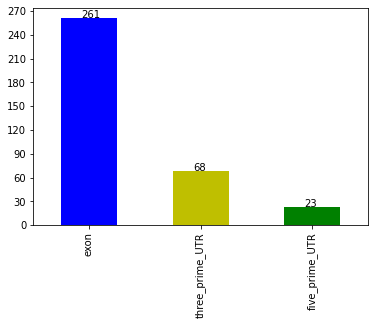

In [61]:
ax = df.annotation_target.value_counts().plot(kind='bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
plt.savefig('../data/res/targets.png',transparent=True, bbox_inches='tight', pad_inches=0)

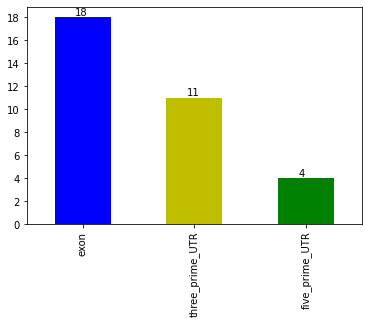

In [62]:
ax = df[df.MITE_target.notnull()].annotation_target.value_counts().plot(kind='bar',color=['b','y','g'])

x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
plt.savefig('../data/res/targets_mites.png',transparent=True, bbox_inches='tight', pad_inches=0)


In [63]:
df.lib.value_counts()

SRR1197126_seedling_leaf                     126
SRR1197127_seedling_root                     117
SRR1197125_germinating_seed_embryo            79
SRR1197128_grain_8_days_after_pollination     30
Name: lib, dtype: int64

In [64]:
df.to_csv(path_res_target, index=None)
path_res_target

'../data/res/res_target.csv'

In [65]:
df.head(2)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE_target,annotation_target
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000393,../data/res/sun_plots/SRR1197126/mrcv_all_Clus...,SRR1197126_seedling_leaf,TraesCS6B02G267500,None,exon
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,0.0,-1.0,1,21,564,584,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:481089083:481090143:-...,1,TraesCS6B02G267500.1:575,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G267500.1,564,584,575,-37.4,-35.4,0.946524,2.0,"1-19,584-566","20-21,565-564[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,3,0.004493,../data/res/sun_plots/SRR1197127/mrcv_all_Clus...,SRR1197127_seedling_root,TraesCS6B02G267500,None,exon


In [66]:
# filter same target with same library 
print(len(df.index))
idx = df.groupby(['Query','Transcript','TStart','TStop'])['DegradomePval'].transform(min) == df['DegradomePval']
print(len(df[idx].index))
df = df[idx]

352
277


In [67]:
df_mirna_res = pd.read_csv(path_mirna_res, sep='\t')
print(len(df_mirna_res.index))
df_mirna_res.head(2)

270


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,Complexity,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
0,1A:117385432-117385825,sun_mites_MITE_T_430_1A_117385432_117385825,394,17,0.135,3,0.941,+,UCUGCACCCUGAAUGAUGAAUAGU,11,0.412,24,Y,-1.0,1,0,0,1,0,1,14,1A,117385432-117385825,117385432,117385825,MITE_21,NaN,intergenic
1,1A:169645857-169646029,mrcv_mites_MITE_T_62663_1A_169645857_169646029,173,16,0.126,3,1.000,+,UAGAGAUUUCAAAUGGAACAC,7,0.500,21,Y,-1.0,0,2,2,9,0,0,3,1A,169645857-169646029,169645857,169646029,DTT_Tdur_Thalos_103H9-1,NaN,intron


In [68]:
#df_merge = pd.merge(df_mirna_res[df_mirna_res.MITE.notnull()],df[df.MITE.notnull()],left_on='Name', right_on='Query')
df_merge = pd.merge(df_mirna_res,df,left_on='Name', right_on='Query')
print(len(df_merge.index))

277


In [69]:
df_merge.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,Complexity,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24,seqname,position,start,end,MITE,mirbase,annotation,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE_target,annotation_target
0,1A:492271831-492271941,sun_all_Cluster_4365_1A_492271831_492271941,111,441,3.492,2,1.0,+,GAGGAGGAGGAGCAGGACAAG,336,0.043,21,Y,-1.0,9,0,70,360,1,1,0,1A,492271831-492271941,492271831,492271941,NaN,NaN,exon,sun_all_Cluster_4365_1A_492271831_492271941,TraesCS5D02G334900.1,1.5,-1.0,1,21,174,194,GAGGAGGAGGAGCAGGACAAG,.: ::::::::.:::::::::,UUGGUCCUGCUUCUCCUCCUC,Cleavage,cdna chromosome:IWGSC:5D:424223039:424223784:-...,1,TraesCS5D02G334900.1:185,sun_all_Cluster_4365_1A_492271831_492271941,TraesCS5D02G334900.1,174,194,185,-44.4,-39.2,0.882883,4.0,"1-18,194-177","19-21,176-174[UP3]",...((((((((((((((((((&))))))))))))))))))...,UUGGUCCUGCUUCUCCUCCUC&GAGGAGGAGGAGCAGGACAAG,2,0.033678,../data/res/sun_plots/SRR1197125/sun_all_Clust...,SRR1197125_germinating_seed_embryo,TraesCS5D02G334900,None,three_prime_UTR


In [70]:
df_merge.to_csv(path_res_final, index=None)
path_res_final

'../data/res/res_prod_target.csv'

In [71]:
df_merge[df_merge['MITE'].notnull()].to_csv(path_res_prod_mite_target_all, index=None)
print(path_res_prod_mite_target_all)
print(len(df_merge[df_merge['MITE'].notnull()].index))
df_merge[df_merge['MITE'].notnull()].head(2)

../data/res/res_prod_mites_target_all.csv
36


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,Complexity,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24,seqname,position,start,end,MITE,mirbase,annotation,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE_target,annotation_target
2,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,0.074,21,Y,-1.0,0,1,0,132,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron,sun_all_Cluster_8835_1B_161992200_161992280,TraesCS5B02G218100.1,1.0,-1.0,1,21,1553,1573,UCUGUUCACAAAUGUAAGACG,: :::::.::::::::::.::,CAUCUUAUAUUUGUGAACGGA,Cleavage,cdna chromosome:IWGSC:5B:391827272:391830741:-...,1,TraesCS5B02G218100.1:1564,sun_all_Cluster_8835_1B_161992200_161992280,TraesCS5B02G218100.1,1553,1573,1564,-32.4,-26.1,0.805556,3.5,"1-19,1573-1555","20-21,1554-1553[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CAUCUUAUAUUUGUGAACGGA&UCUGUUCACAAAUGUAAGACG,0,0.002596,../data/res/sun_plots/SRR1197128/sun_all_Clust...,SRR1197128_grain_8_days_after_pollination,TraesCS5B02G218100,DTT_Hvul_Oleus_AF490468-1,exon
5,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,0.047,24,Y,-1.0,29,17,29,59,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS7B02G175300.2,2.5,-1.0,1,24,1502,1525,UGAGACGGGUAAUUUGGAACGGAG,::::::::::::::::.:::: .:,CUCCGUUCCAAAUUACUCGUCGUA,Cleavage,cdna chromosome:IWGSC:7B:246505474:246508663:-...,1,TraesCS7B02G175300.2:1516,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS7B02G175300.2,1502,1525,1516,-44.0,-37.1,0.843182,4.0,"1-2,1525-1524;4-24,1522-1502","3-3,1523-1523[SIL]",(((((((((((((((((((((.((&)).))))))))))))))))))))),CUCCGUUCCAAAUUACUCGUCGUA&UGAGACGGGUAAUUUGGAACGGAG,2,0.044973,../data/res/sun_plots/SRR1197128/sun_mites_MIT...,SRR1197128_grain_8_days_after_pollination,TraesCS7B02G175300,None,exon


In [72]:
print(len(df_merge[df_merge['MITE'].notnull()].index))
df_merge[df_merge['MITE'].notnull()]

36


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,Complexity,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24,seqname,position,start,end,MITE,mirbase,annotation,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE_target,annotation_target
2,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,0.074,21,Y,-1.0,0,1,0,132,0,0,2,1B,161992200-161992280,161992200,161992280,MITE_1712,hvu-miR6197,intron,sun_all_Cluster_8835_1B_161992200_161992280,TraesCS5B02G218100.1,1.0,-1.0,1,21,1553,1573,UCUGUUCACAAAUGUAAGACG,: :::::.::::::::::.::,CAUCUUAUAUUUGUGAACGGA,Cleavage,cdna chromosome:IWGSC:5B:391827272:391830741:-...,1,TraesCS5B02G218100.1:1564,sun_all_Cluster_8835_1B_161992200_161992280,TraesCS5B02G218100.1,1553,1573,1564,-32.4,-26.1,0.805556,3.5,"1-19,1573-1555","20-21,1554-1553[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CAUCUUAUAUUUGUGAACGGA&UCUGUUCACAAAUGUAAGACG,0,0.002596,../data/res/sun_plots/SRR1197128/sun_all_Clust...,SRR1197128_grain_8_days_after_pollination,TraesCS5B02G218100,DTT_Hvul_Oleus_AF490468-1,exon
5,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,0.047,24,Y,-1.0,29,17,29,59,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS7B02G175300.2,2.5,-1.0,1,24,1502,1525,UGAGACGGGUAAUUUGGAACGGAG,::::::::::::::::.:::: .:,CUCCGUUCCAAAUUACUCGUCGUA,Cleavage,cdna chromosome:IWGSC:7B:246505474:246508663:-...,1,TraesCS7B02G175300.2:1516,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS7B02G175300.2,1502,1525,1516,-44.0,-37.1,0.843182,4.0,"1-2,1525-1524;4-24,1522-1502","3-3,1523-1523[SIL]",(((((((((((((((((((((.((&)).))))))))))))))))))))),CUCCGUUCCAAAUUACUCGUCGUA&UGAGACGGGUAAUUUGGAACGGAG,2,0.044973,../data/res/sun_plots/SRR1197128/sun_mites_MIT...,SRR1197128_grain_8_days_after_pollination,TraesCS7B02G175300,None,exon
6,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,0.047,24,Y,-1.0,29,17,29,59,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS2A02G281000.1,2.5,-1.0,1,24,1939,1962,UGAGACGGGUAAUUUGGAACGGAG,:::::::::.::::::..::::..,CUCCGUUCCGAAUUACUUGUCUUG,Cleavage,cdna chromosome:IWGSC:2A:469456196:469466847:-...,1,TraesCS2A02G281000.1:1953,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS2A02G281000.1,1939,1962,1953,-44.0,-37.0,0.840909,4.5,"2-24,1961-1939","1-1,1962-1962[UP5]",(((((((((((((((((((((((.&.))))))))))))))))))))))),CUCCGUUCCGAAUUACUUGUCUUG&UGAGACGGGUAAUUUGGAACGGAG,1,0.007971,../data/res/sun_plots/SRR1197126/sun_mites_MIT...,SRR1197126_seedling_leaf,TraesCS2A02G281000,DTT_Hvul_Pan_M801L24-1,exon
7,2A:133702671-133702770,sun_mites_MITE_T_99232_2A_133702671_133702770,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,0.047,24,Y,-1.0,29,17,29,59,53,101,2001,2A,133702671-133702770,133702671,133702770,DTT_Tmon_Icarus_BG607724-1,NaN,promoter,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS1A02G090300.1,4.0,-1.0,1,24,2024,2047,UGAGACGGGUAAUUUGGAACGGAG,:::::::: .::::::..::: ::,CUCCGUUCGGAAUUACUUGUCGCA,Cleavage,cdna chromosome:IWGSC:1A:80297144:80309314:1 g...,1,TraesCS1A02G090300.1:2038,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS1A02G090300.1,2024,2047,2038,-44.0,-32.5,0.738636,5.5,"1-2,2047-2046;4-15,2044-2033;17-24,2031-2024","3-3,2045-2045[SIL];16-16,2032-2032[SIL]",((((((((.((((((((((((.((&)).)))))))))))).)))))))),CUCCGUUCGGAAUUACUUGUCGCA&UGAGACGGGUAA

In [73]:
#micros = set(df_merge[df_merge['MITE'].notnull()]['Name'].tolist())
x = df_merge.sort_values('MITE')['Name'].tolist()

micros = sorted(set(x), key=x.index)
micros_t = {}
index = 1
for m in micros:
    micros_t[index] = m
    index += 1

In [74]:
import math


In [75]:
#df_merge[df_merge['Name'] == 'mrcv_all_Cluster_19446_4B_613386213_613386366']
import numpy as np

In [82]:
mirna_names = []
for x in micros_t.values():
    name = x.split('_')[-3:]
    name = '_'.join(name)
    mirna_names.append(name)

<ipython-input-113-5e2af3f91bce>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


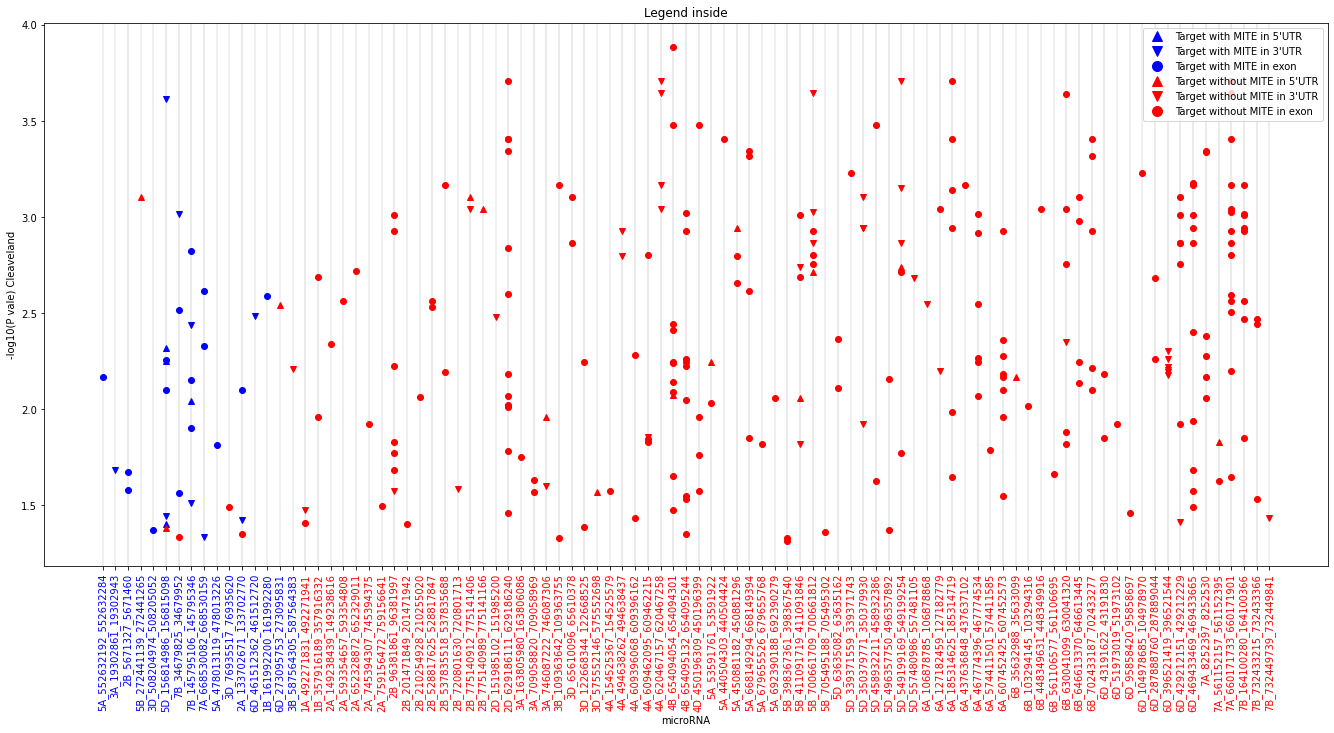

In [113]:
plt.figure()
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

plt.rcParams["figure.figsize"] = (23,10)
plt.xticks(list(micros_t.keys()),labels=mirna_names,rotation=90)
plt.ylabel('-log10(P vale) Cleaveland')
plt.xlabel('microRNA: in blue produced by a MITE and red otherwise')

#fig = plt.figure()
ax = plt.subplot(111)

for i in plt.gca().get_xticklabels():
    micro = i.get_text()
    if str(df_merge[df_merge['Name'].str.contains(micro)].iloc[0]['MITE']) != "nan":
        i.set_color("blue")
    else:
        i.set_color("red")
    
plotdata = []
#
for k,v in df_merge.sort_values('MITE').iterrows():

    res = list(micros_t.keys())[list(micros_t.values()).index(v['Name'])]
    #print(res, v['Name'])
    ax.axvline(x=res, color='#EBEBEB')

for k,v in df_merge.sort_values('MITE').iterrows():

    res = list(micros_t.keys())[list(micros_t.values()).index(v['Name'])]
    #print(res, v['Name'])
#    plt.axvline(x=res, color='#EBEBEB')

    if v['MITE_target']:
        color = 'b'
    else:
        color = 'r'
    if v['annotation_target'] == 'exon':
        color += 'o'
    if v['annotation_target'] == 'five_prime_UTR':
        color += '^'
    if v['annotation_target'] == 'three_prime_UTR':
        color += 'v'
    ax.plot(res,math.log10(v['DegradomePval']) * -1 ,color)

    
    
plt.title('Legend inside')



from matplotlib.patches import Patch
from matplotlib.lines import Line2D


legend_elements = [
    Line2D([0], [0],linestyle = 'None', marker='^', color='blue', label='Target with MITE in 5\'UTR',markerfacecolor='blue', markersize=10),
    Line2D([0], [0], linestyle = 'None',marker='v', color='blue', label= 'Target with MITE in 3\'UTR',markerfacecolor='blue', markersize=10),
    Line2D([0], [0], linestyle = 'None',marker='o', color='blue', label= 'Target with MITE in exon',markerfacecolor='blue', markersize=10),
    Line2D([0], [0],linestyle = 'None', marker='^', color='red', label='Target without MITE in 5\'UTR',markerfacecolor='red', markersize=10),
    Line2D([0], [0],linestyle = 'None', marker='v', color='red', label= 'Target without MITE in 3\'UTR',markerfacecolor='red', markersize=10),
    Line2D([0], [0],linestyle = 'None', marker='o', color='red', label= 'Target without MITE in exon ',markerfacecolor='red', markersize=10),
]

# Create the figure
ax.legend(handles=legend_elements, loc='upper right', )
#plt.show()


xbox1 = TextArea("Data1-x ", textprops=dict(color="r", size=15))
xbox2 = TextArea("and ", textprops=dict(color="k", size=15))
xbox3 = TextArea("Data2-x ", textprops=dict(color="b", size=15))

xbox = HPacker(children=[xbox1, xbox2, xbox3],
                  align="center", pad=0, sep=5)

anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=0., frameon=False,
                                      bbox_to_anchor=(0.3, -0.07),
                                      bbox_transform=ax.transAxes, borderpad=0.)




In [77]:
rows = df_merge[df_merge['MITE'].notnull() ]
len(set(rows['Name'].tolist()))

16

In [320]:
rows = df_merge[df_merge['MITE'].notnull() & df_merge['MITE_target'].notnull()]
len(set(rows['Name'].tolist()))

12

In [322]:
rows = df_merge[df_merge['MITE'].notnull() & df_merge['MITE_target'].isnull()]
len(set(rows['Name'].tolist()))

7

In [ ]:
# some final numbers

In [ ]:
df.head(2)

In [ ]:
df_merge.head(1)

In [ ]:
print(">>>>Micros")
micros = len(df_merge['Name'].unique())
print(micros)

print(">>>>MITEs  en el sitio de produccion")
mites_prod_site = len(df_merge[df_merge['MITE'].notnull()]['Name'].unique())
print(mites_prod_site, int(mites_prod_site * 100 / micros ),'%')


print(">>>>Micros con MITEs en el target")
mites_target_sites = len(df_merge[df_merge['MITE_target'].notnull()]['Name'].unique())
print(mites_target_sites,int(mites_target_sites * 100 / micros ),'%')


print(">>>>>Micros con MITEs  en el sitio de produccion y en el target")
mites_target_prod = len(df_merge[df_merge['MITE'].notnull() & df_merge['MITE_target'].notnull()]['Name'].unique())
print(mites_target_prod, int(mites_target_prod * 100 / mites_prod_site ),'% del total de micros con mites en el sitio de prod:', mites_prod_site)

print(">MITEs  en el target, donde caen?")
print(df_merge[df_merge['MITE_target'].notnull()].annotation_target.value_counts())

print(">MITEs  en el sitio de produccion, donde caen?")
print(df_merge[df_merge['MITE'].notnull()].annotation_target.value_counts())


In [ ]:
df_merge[df_merge['MITE_target'].notnull()].groupby(['Name'])['annotation_target'].first()

In [ ]:
df_merge[df_merge['MITE'].notnull() & df_merge['MITE_target'].notnull()]

In [ ]:
df_merge[df_merge['MITE'].notnull() & df_merge['MITE_target'].notnull()]

In [ ]:
df_mites = df[df.MITE != '']
df[df.MITE != ''][['SiteID','Query','Transcript','TStart','TStop','MITE','Sequence']].head()

In [ ]:
df_mirna_res = pd.read_csv(path_mirna_res, sep='\t')
df_mirna_res.rename(columns={'MITE':'MITE_prod'}, inplace=True)
print(len(df_mirna_res.index))
df_mirna_res.head(2)

In [ ]:
df_mirna_res_mites = df_mirna_res[df_mirna_res.MITE_prod.notnull()]
print(len(df_mirna_res_mites.index))


In [ ]:
df_mirna_res_mites['Name'] = df_mirna_res_mites.Name.str.split("|").str[0]

In [ ]:
df_mirna_res_mites_for_merge = df_mirna_res_mites[['Name','#Locus','MajorRNA','MITE_prod']]

In [ ]:
df_merge = pd.merge(df_mites,df_mirna_res_mites,left_on='Query', right_on='Name')

In [ ]:
df_new = df_merge[['SiteID','DegradomeCategory','Name','#Locus','MajorRNA','MITE','MITE_prod']]

In [ ]:
df_merge.head(2)

In [ ]:
df_merge['equal_mite'] = 0
for k,v in df_merge.iterrows():
    prods = v.MITE_prod.split(',')
    target = v.MITE.split(',')
    prods = set(filter(None, prods))
    target = set(filter(None, target))
    inter = target.intersection(prods)
    if inter:
        print(v.SiteID, v.Name, inter)
        df_merge.at[k, 'equal_mite'] = 1

In [ ]:
df_merge[df_merge.Name=='sun_all_Cluster_8835']

In [ ]:
total_ele = len(df_merge.index)
equal_mite = len(df_merge[df_merge.equal_mite==1].index)
print(equal_mite * 100 /total_ele)

In [ ]:
df_merge.to_csv(path_res_final, index=None)
path_res_final